In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler

import helper

## Flowers

https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

In [2]:
class ImageFolderSubClasses(datasets.ImageFolder):
    def __init__(self, root, subclasses, transform=None):
        super(ImageFolderSubClasses, self).__init__(root, transform=transform)

    def _find_classes(self, dir):

        classes = [d.name for d in os.scandir(dir) if d.is_dir() and d.name in subclasses]
        
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

In [3]:
# datatransforms = {"train": transforms.Compose([transforms.RandomRotation(30),
#                                                transforms.Resize(120),
#                                                transforms.CenterCrop(120),
#                                                transforms.ToTensor(),
#                                                transforms.Normalize([0.5, 0.5, 0.5], 
#                                                                     [0.5, 0.5, 0.5])]),
#                   "valid": transforms.Compose([transforms.Resize(120),
#                                                transforms.CenterCrop(120),
#                                                transforms.ToTensor(),
#                                                transforms.Normalize([0.5, 0.5, 0.5], 
#                                                                     [0.5, 0.5, 0.5])]),
#                   "test": transforms.Compose([transforms.Resize(120),
#                                               transforms.CenterCrop(120),
#                                               transforms.ToTensor(),
#                                               transforms.Normalize([0.5, 0.5, 0.5], 
#                                                                    [0.5, 0.5, 0.5])])}
datatransforms = {"train": transforms.Compose([transforms.Resize(120),
                                               transforms.CenterCrop(120),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.5, 0.5, 0.5], 
                                                                    [0.5, 0.5, 0.5])]),
                  "valid": transforms.Compose([transforms.Resize(120),
                                               transforms.CenterCrop(120),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.5, 0.5, 0.5], 
                                                                    [0.5, 0.5, 0.5])]),
                  "test": transforms.Compose([transforms.Resize(120),
                                              transforms.CenterCrop(120),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.5, 0.5, 0.5], 
                                                                   [0.5, 0.5, 0.5])])}

In [4]:
basedir = '/home/q1park/visions/data/'
subclasses = ['1', '10', '20']
batchsize = 25

dirs = {"train": basedir + "train", 
        "valid": basedir + "valid", 
        "test": basedir + "test"}

imgsets = {x: ImageFolderSubClasses(dirs[x], subclasses = subclasses, \
                                    transform=datatransforms[x]) \
           for x in ["train", "valid", "test"]}
loaders = {x: torch.utils.data.DataLoader(imgsets[x], batch_size=batchsize, shuffle=True) \
           for x in ["train", "valid", "test"]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


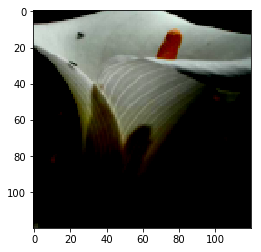

In [5]:
def plot_image(image):
    fig, ax = plt.subplots(1, 1)
    
    if image.shape[2] == 1:
        image = image[:, :, 0]
    ax.imshow(image, cmap = 'gray')
    plt.show()

datarunner = iter(loaders["train"]);
images, labels = next(datarunner)

npimg = images[0].numpy().transpose((1, 2, 0))
print(labels[0].numpy())
plot_image(npimg )

In [6]:
def make_checkpoint(model, check_name):
    checkpoint = {'state_dict': model.state_dict()}
    torch.save(checkpoint, check_name)

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network()
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        # pool after conv reduces image size 120 > 60 > 30 > 15
        self.fc1 = nn.Linear(64*15*15, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)

        self.dropout = nn.Dropout(p = 0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x) ) ) )
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x) ) ) )
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x) ) ) )

        x = x.view(-1, 64*15*15)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return F.log_softmax(x, dim = 1)

In [12]:
model = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
epochs = 40
printevery=5

for epoch in range(1, epochs):
    trainloss = 0.0
    validloss = 0.0
    
    model.train();
    for data, target in loaders["train"]:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()*data.size(0)
        
    model.eval();
    with torch.no_grad():
        for data, target in loaders["test"]:
            output = model(data)
            vloss = criterion(output, target)
            validloss += vloss.item()*data.size(0)

        trainloss = trainloss/len(loaders["train"].dataset)
        validloss = validloss/len(loaders["test"].dataset)

        if epoch%printevery == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, trainloss, validloss))
pass;

Epoch: 5 	Training Loss: 0.783343 	Validation Loss: 1.043989
Epoch: 10 	Training Loss: 0.518476 	Validation Loss: 0.651064
Epoch: 15 	Training Loss: 0.375041 	Validation Loss: 0.452327
Epoch: 20 	Training Loss: 0.276809 	Validation Loss: 0.299767
Epoch: 25 	Training Loss: 0.223072 	Validation Loss: 0.406469
Epoch: 30 	Training Loss: 0.213783 	Validation Loss: 0.367575
Epoch: 35 	Training Loss: 0.138163 	Validation Loss: 0.329080


In [10]:
checkmark = 'checkpoint_'+'1'+'.pth'
make_checkpoint(model, checkmark)

model_fresh = load_checkpoint(checkmark)
print(model_fresh)

Network(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=14400, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
  (dropout): Dropout(p=0.4)
)
